### Get from WANDB

In [1]:
import wandb
from tqdm import tqdm
import shutil
project = 'node_effect'
# group = 'eval'

In [2]:
shutil.rmtree('./results/ll_models')
api = wandb.Api()
runs = api.runs(f'{project}', filters={"state": "finished"})
print(runs)

<Runs cybershiptrooper/node_effect>


In [3]:
files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv', 'results_accuracy.csv']
print("Downloading files for runs")
import concurrent.futures

def download_files(run):
    for file in run.files():
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_files, runs), total=len(runs)))

100%|██████████| 69/69 [00:44<00:00,  1.53it/s]


### Read Files

In [1]:
bad_runs = ['38', '16', # these are constant runs
            '4', # these are runs for which I haven't saved the model on wandb for one of siit or iit
]

In [2]:
import os
os.listdir('results/ll_models')

['11', '16', '8', '21', '38', '24', '4', '3', '13']

In [3]:
import dataframe_image as dfi

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd

def walk_wandb_dir_and_get_results(weight: float = 510, make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        folder = os.path.join('./results/ll_models/', run, f'results_{weight}')
        result = os.path.join(folder, 'results.csv')
        result_accuracy = os.path.join(folder, 'results_accuracy.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        elif os.path.exists(result_accuracy):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result_accuracy), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results, results_kl_div

In [5]:
results, results_kl = walk_wandb_dir_and_get_results()
results_tracr, results_kl_tracr = walk_wandb_dir_and_get_results(weight="tracr", make_image=False)
results_iit, results_kl_iit = walk_wandb_dir_and_get_results(weight="110", make_image=False)

In [6]:
for run in bad_runs:
    results.pop(run, None)
    results_kl.pop(run, None)
    results_tracr.pop(run, None)
    results_kl_tracr.pop(run, None)
    results_iit.pop(run, None)
    results_kl_iit.pop(run, None)

### Make DF

In [7]:
from circuits_benchmark.utils.get_cases import get_cases
from utils.node_effect_utils import *
from utils.plotter import plot_results_in_box_plot, plot_results_in_scatter_plot

In [8]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)

Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']


In [9]:
unique_runs = list(df_combined_tracr['run'].unique()) # GLOBAL!!!
# remove 38, 16 from from dataframes
# iit_unique_runs
print(f"Unique runs: {unique_runs}")
all_cases = get_cases(indices=unique_runs)
for case in all_cases:
    case.get_tracr_output()

Unique runs: ['11', '8', '21', '24', '3', '13']


In [10]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)
remove_nodes_with_zero_effect(df_combined, df_combined_tracr, df_combined_kl, df_combined_kl_tracr, cases=all_cases)
remove_nodes_with_zero_effect(df_combined_iit, df_combined_tracr_iit, df_combined_kl_iit, df_combined_kl_tracr_iit, cases=all_cases)

Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8


In [11]:
# df_combined_kl.groupby('run').get_group('11')

### Box Plots

In [12]:
results_tracr.keys(), results.keys(), results_iit.keys()

(dict_keys(['11', '8', '21', '24', '3', '13']),
 dict_keys(['11', '8', '21', '24', '3', '13']),
 dict_keys(['11', '8', '21', '24', '3', '13']))

Strict

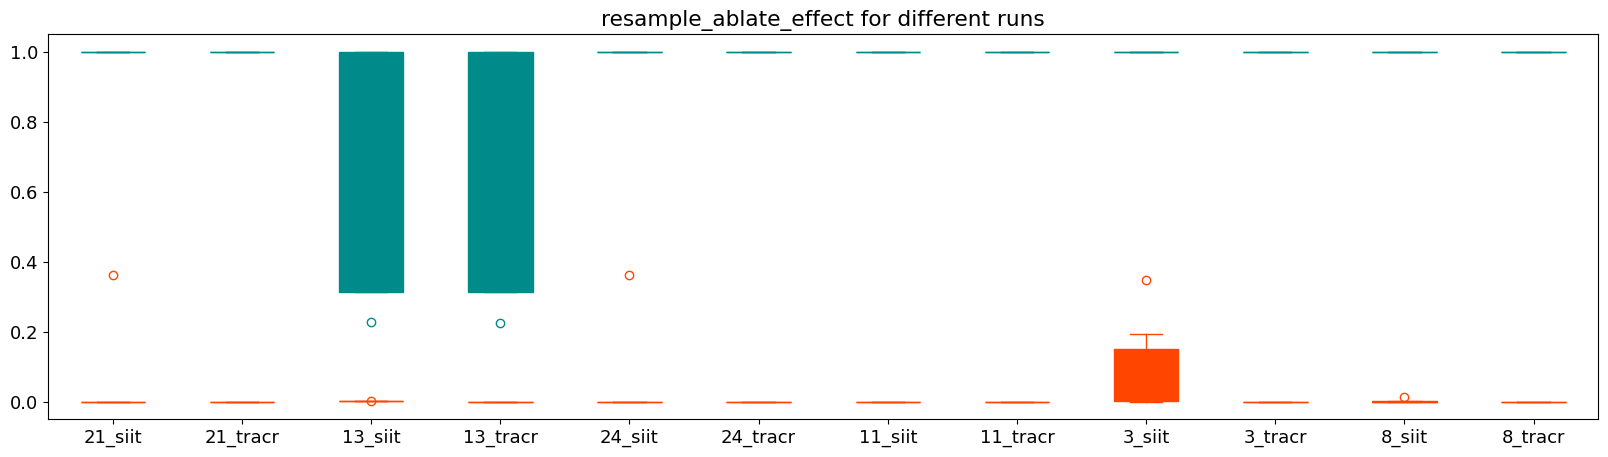

In [13]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
                        key = "resample_ablate_effect",
                        normalize_by_runs=False)

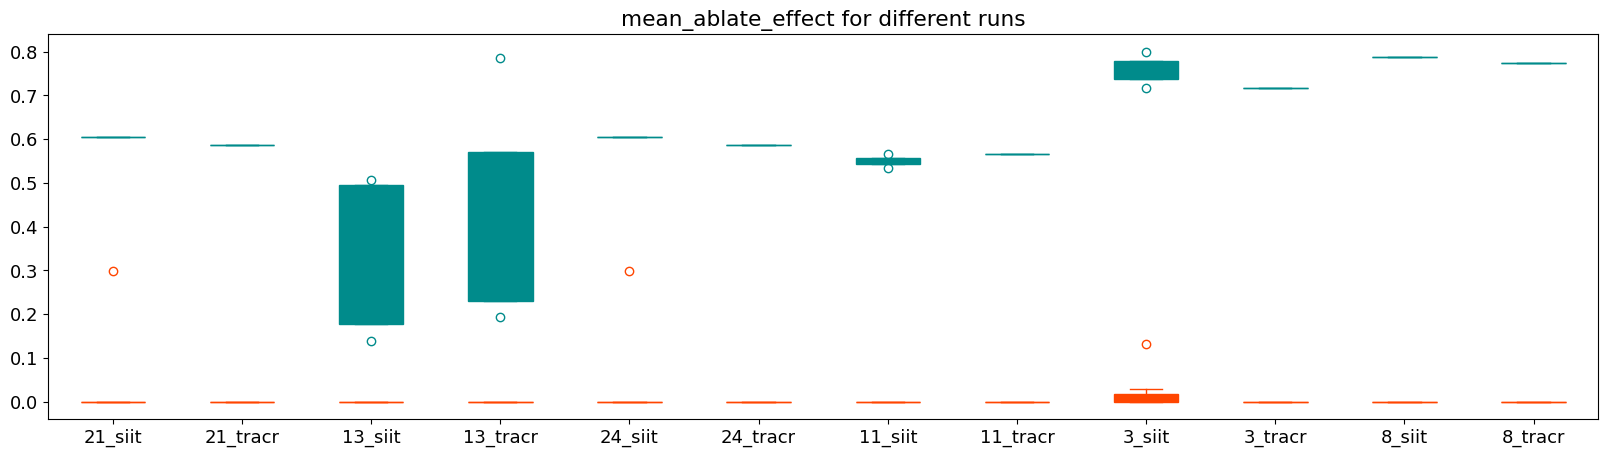

In [14]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             key = "mean_ablate_effect",
             normalize_by_runs=False)

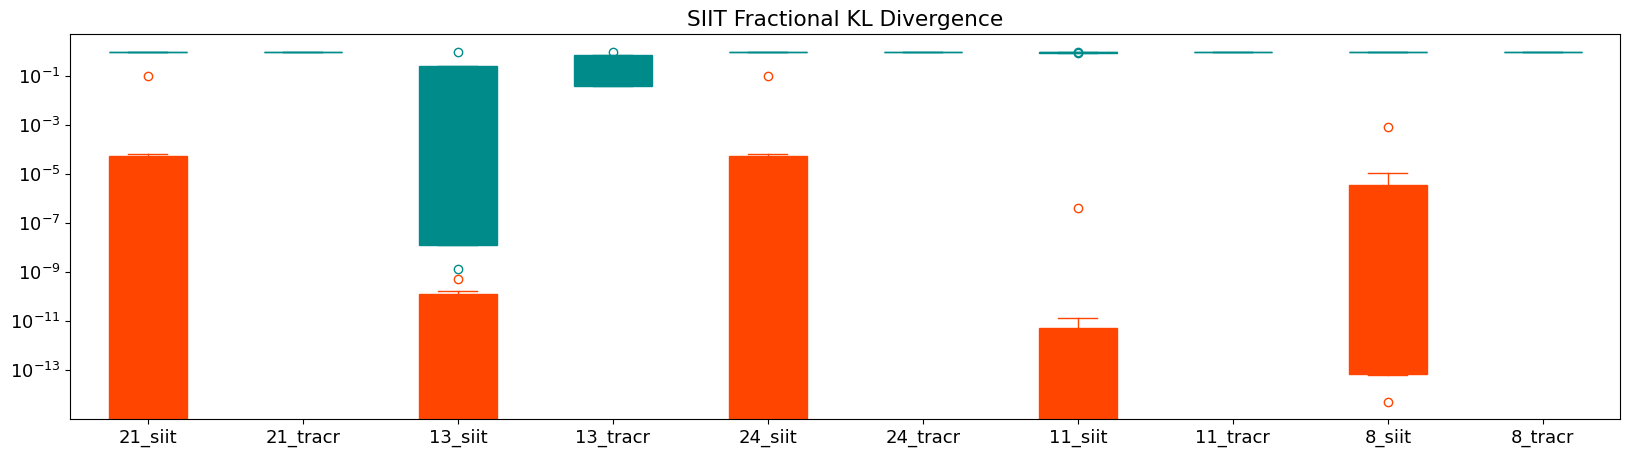

In [15]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr, 
             key = "resample_ablate_effect",
             title="SIIT Fractional KL Divergence",
             normalize_by_runs=True,
             plot_y_log=True)

IIT

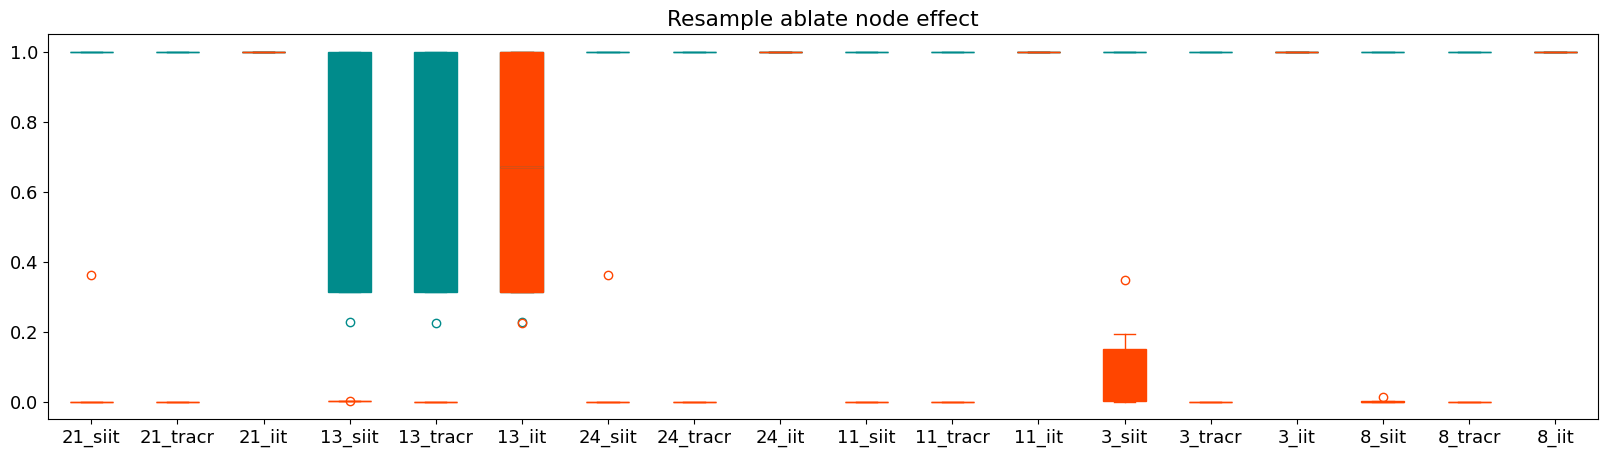

In [16]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             df_iit=df_combined_iit,
             key = "resample_ablate_effect",
             title = "Resample ablate node effect",
             normalize_by_runs=False)

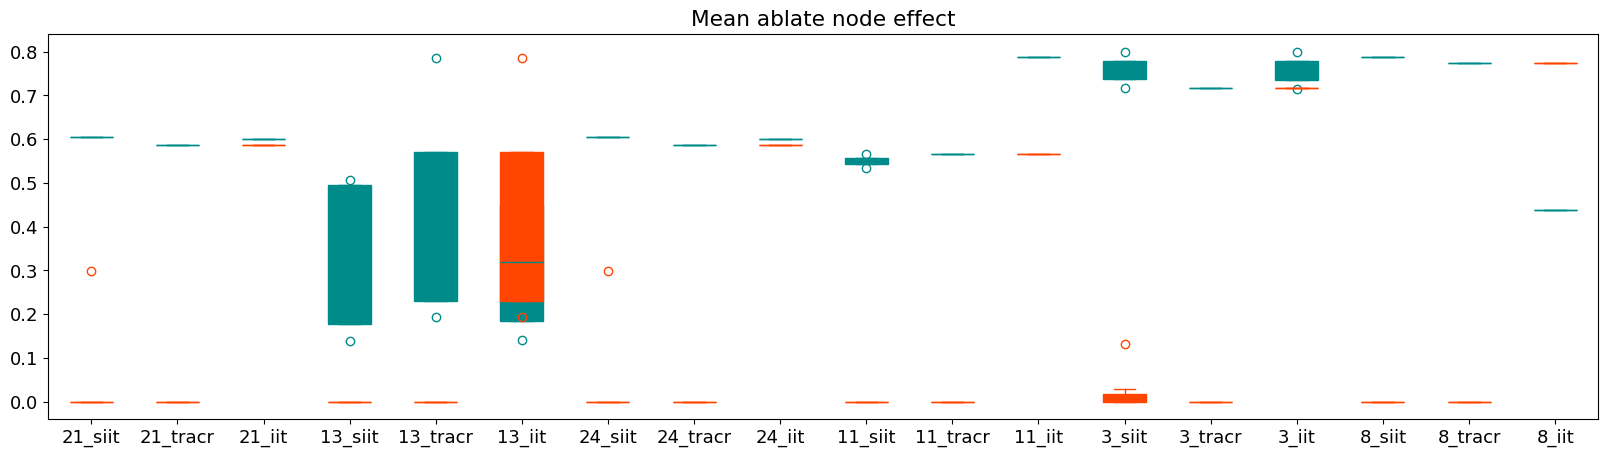

In [17]:
plot_results_in_box_plot(df_combined, df_combined_tracr,
             df_iit=df_combined_iit,
             key = "mean_ablate_effect",
             title = "Mean ablate node effect",
             normalize_by_runs=False)

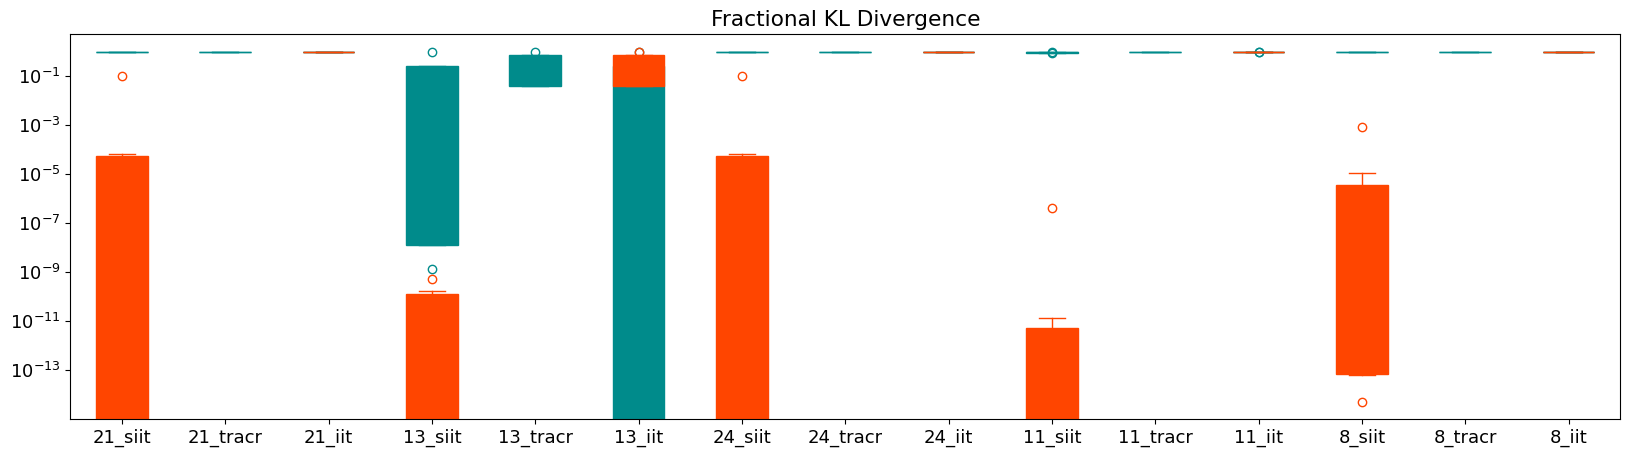

In [18]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr,
             df_iit=df_combined_kl_iit,
             key = "resample_ablate_effect",
             title="Fractional KL Divergence",
             normalize_by_runs=True,
                plot_y_log=True)

### Scatter

In [19]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=True)

[1.0, 0.6416721029783914, 1.0, 1.0, 0.9999999999999996, 1.0] [0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999368] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.22456332161373846, 0.0016550457713428333, 0.22456332161373846, 0.12748049682176954, 0.21787919960393928, 0.1111111111111041]
6 6


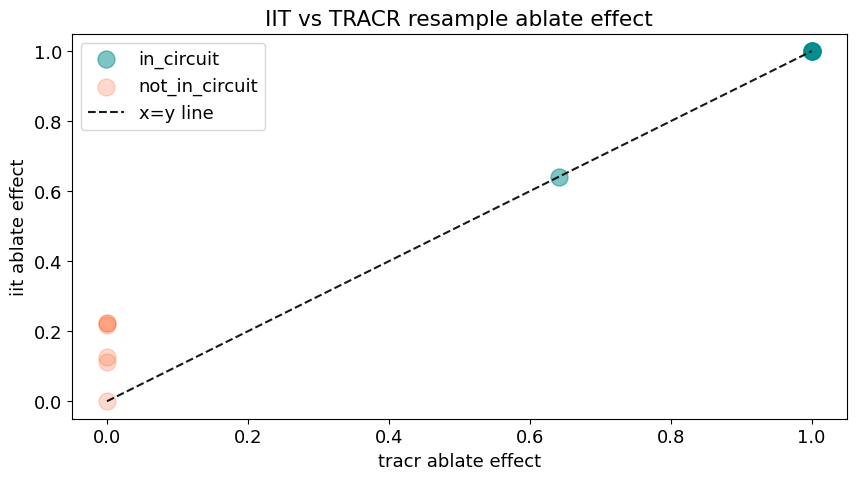

In [20]:
plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs TRACR resample ablate effect",
                mean=True)

In [21]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=False)

In [22]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="IIT vs TRACR resample ablate effect",
#                 mean=False)

[1.0, 0.6411932363790154, 1.0, 1.0, 0.9999999999999996, 1.0] [0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999368] [0.040091275763517356, 0.0016189334366709669, 0.040091275763517356, 0.0, 0.10620629496079521, 0.0014946442620427222] [0.22456332161373846, 0.0016550457713428333, 0.22456332161373846, 0.12748049682176954, 0.21787919960393928, 0.1111111111111041]
6 6


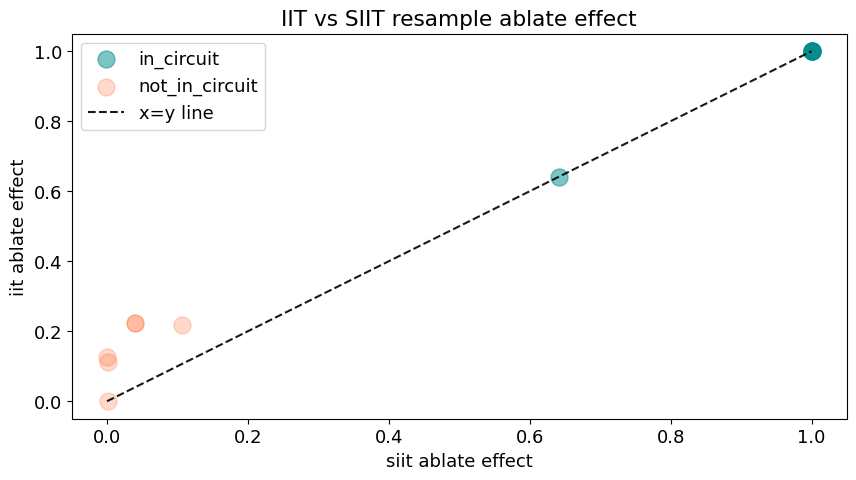

In [30]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=True,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)


[1.0, 0.227374332949931, 0.9988696693473456, 0.3396592738714397, 0.9988696693473456, 1.0, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 1.0] [0.9999999999999368, 0.2273776607403042, 0.998869669347339, 0.3396624340941708, 0.998869669347339, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368] [0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016188418601002, 0.0016188418601002, 0.0016190269294115, 0.0016188418601002, 0.0016188418601002, 0.0016192062502135, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0] [0.0, 0.0, 0.0, 0.9996299231814242, 0.0, 0.021439971342285, 0.0, 0.0, 0.9999999999999368, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.001836065327556, 0.0, 0.0, 0.0, 0.

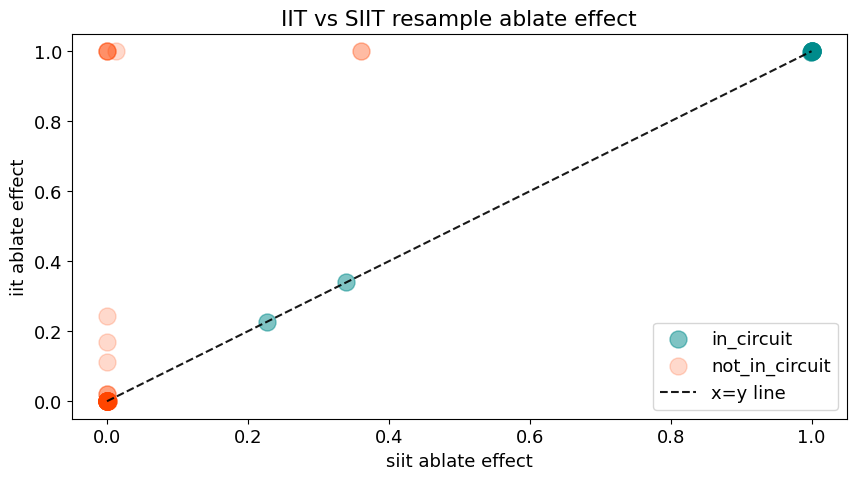

In [23]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)


### Other Plots

In [24]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "mean_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=True)

In [25]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "mean_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=False)

In [26]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=True)

In [27]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "mean_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=False)

In [28]:
# plot_results_in_scatter_plot(df_combined_kl, df_combined_kl_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=True,
#                 plot_minmax_lines=False,
#                 mean=True)

In [29]:
# plot_results_in_scatter_plot(df_combined_kl_iit, df_combined_kl_tracr_iit,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=True,
#                 plot_minmax_lines=False,
#                 mean=True)